In [88]:
import numpy as np
import sys
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from bisect import bisect_left
sys.path.append('../../') # Your path should contain the parent GitHub repository

import wdtools

from astropy.io import fits

In [90]:
# Use wavelength and noise from a real spectrum with median SN ~ 40

with fits.open('sample_spectrum.fits') as f:
    real_flux = f[1].data['flux']
    real_wl = 10**f[1].data['loglam']
    real_ivar = f[1].data['ivar']
    
c1 = bisect_left(real_wl, 3750)
c2 = bisect_left(real_wl, 7000)

real_wl = real_wl[c1:c2]
real_flux = real_flux[c1:c2]
real_ivar = real_ivar[c1:c2]

In [81]:
make_plot = False

gfp = wdtools.GFP(resolution = 1)
wl = real_wl

Nteff = 5
Nlogg = 5

teffs = np.linspace(8000, 35000, Nteff)
loggs = np.linspace(7, 9, Nlogg)

param_grid = np.array(list(itertools.product(teffs,loggs)))
predicted = [];
rvs = [];

SN = 30

for param in tqdm(param_grid):
    
    teff,logg = param
    
    if make_plot:
        print('--'*25)
        print('Testing T = %i, logg = %.2f' % (teff, logg))

    fl = gfp.spectrum_sampler(wl, teff, logg)
    fl = (fl / np.median(fl)) * np.nanmedian(real_flux)
    sigma =  1 / np.sqrt(real_ivar) #fl / SN # assume shot noise
    fl += sigma * np.random.normal(size = len(fl))
    ivar = 1 / sigma**2 #np.repeat(1 / sigma**2, len(fl))

    labels, e_labels, redchi = gfp.fit_spectrum(wl, fl, ivar, mcmc = False, 
                                                fullspec = False, polyorder = 0,
                                                lines = ['beta', 'gamma', 'delta', 'eps', 'h8'],
                                                make_plot = make_plot, crop = (3800, 7000),
                                                plot_init = make_plot,
                                                verbose = make_plot
                                               )

    predicted.append([labels[0], labels[1]])
    rvs.append(labels[-1])
    
predicted = np.array(predicted)
rvs = np.array(rvs)

100%|██████████| 25/25 [03:05<00:00,  7.42s/it]


Text(0.5, 1.0, '$\\log{g}$')

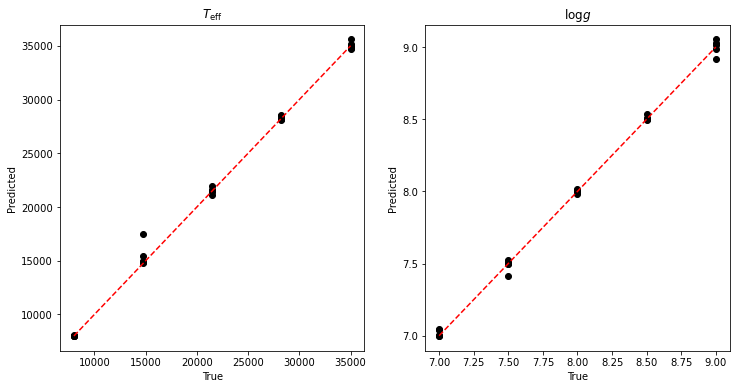

In [91]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

x = param_grid[:, 0]
y = predicted[:, 0]

plt.scatter(x, y, color = 'k')
plt.plot([x[0], x[-1]], [x[0], x[-1]], color = 'r', linestyle = '--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('$T_{\mathrm{eff}}$')

plt.subplot(122)

x = param_grid[:, 1]
y = predicted[:, 1]

plt.scatter(x, y, color = 'k')
plt.plot([x[0], x[-1]], [x[0], x[-1]], color = 'r', linestyle = '--')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('$\log{g}$')

Text(0, 0.5, '$\\log{g}$')

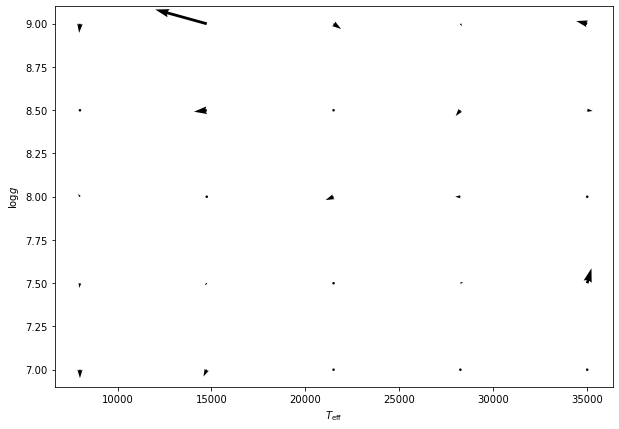

In [92]:
x = param_grid[:, 0]
y = param_grid[:, 1]

dx = param_grid[:, 0] - predicted[:, 0]
dy = param_grid[:, 1] - predicted[:, 1]

col = np.sqrt((dx / dx.mean())**2 + (dy / dy.mean())**2)

plt.figure(figsize = (10, 7))

plt.quiver(x, y, dx, dy, angles = 'xy', scale_units = 'xy', scale = 1, width = 0.005)

plt.xlabel('$T_{\mathrm{eff}}$')
plt.ylabel('$\log{g}$')

Text(0.5, 1.0, '$\\mu$ = 1 km/s, $\\sigma$ = 22 km/s')

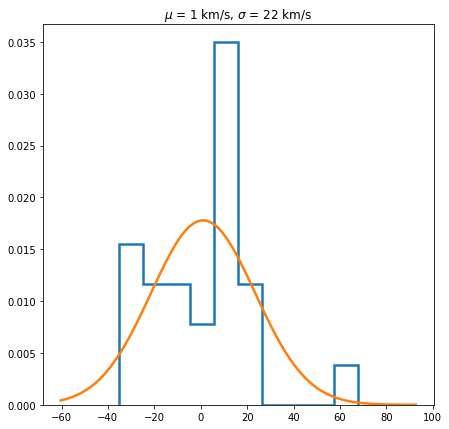

In [93]:
plt.figure(figsize = (7,7))

plt.hist(rvs, histtype = 'step', density = True, lw = 2.5)
gs = stats.norm.fit(rvs)

rvgrid = np.linspace(rvs.min() - 25, rvs.max() + 25, 100)

plt.plot(rvgrid, stats.norm.pdf(rvgrid, loc = gs[0], scale = gs[1]), lw = 2.5)

plt.title(r'$\mu$ = %i km/s, $\sigma$ = %i km/s' % (gs[0], gs[1]))